In [1]:
%pylab inline
import jax
import jax.numpy as np
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions
from nsec.samplers import ScoreHamiltonianMonteCarlo
from nsec.datasets.two_moons import get_two_moons
from nsec.replica_exchange_mc import ReplicaExchangeMC

Populating the interactive namespace from numpy and matplotlib


In [7]:
from functools import partial

def logp(x, sigma):
    return get_two_moons(sigma+0.01).log_prob(x).squeeze()

dlogp = jax.jit(jax.grad(logp))

def score(x, sigma):
    sigma = sigma.reshape((4,1,1))
    return np.expand_dims(np.stack([dlogp(x[i,0], sigma[i,0]) for i in range(4)],axis=0),axis=1)

In [8]:
logp(np.zeros([4,1,2]).astype('float32'),
      np.ones([4,1,1]).astype('float32')).shape

(4,)

In [9]:
score(np.zeros([4,1,2]).astype('float32'),
      np.ones([4,1,1]).astype('float32')).shape

(4, 1, 2)

In [10]:
# def score(x, s):
#     return np.zeros([4,1,2])

In [11]:
sigmas = 0.25**np.arange(4).astype('float32')[::-1]
step_size = 0.1*np.sqrt(sigmas).reshape((4,1,1))
sigmas = np.concatenate([np.array([0.01]), sigmas[1:]],axis=-1)

In [12]:
sigmas

DeviceArray([0.01  , 0.0625, 0.25  , 1.    ], dtype=float32)

In [13]:
step_size

DeviceArray([[[0.0125]],

             [[0.025 ]],

             [[0.05  ]],

             [[0.1   ]]], dtype=float32)

In [14]:
def make_kernel_fn(target_log_prob_fn, target_score_fn):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=step_size, 
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

In [15]:
remc = ReplicaExchangeMC(
    target_score_fn=score,
    inverse_temperatures=sigmas,
    make_kernel_fn=make_kernel_fn,
    num_delta_logp_steps=16)

In [16]:
def trace_swaps(unused_state, results):
  return (results.is_swap_proposed_adjacent,
          results.is_swap_accepted_adjacent)

In [17]:
num_results = int(1e4)
num_burnin_steps = int(1e1)

In [18]:
samples, (is_swap_proposed_adjacent, is_swap_accepted_adjacent) = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=np.zeros([1,2]),
        kernel=remc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=trace_swaps,
        seed=jax.random.PRNGKey(0))

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


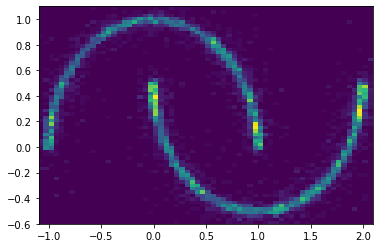

In [20]:
hist2d(samples[:,0,0],samples[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [21]:
dist_target=get_two_moons(sigmas[0]+0.02)

In [22]:
samps = dist_target.sample(10000, seed=jax.random.PRNGKey(0))

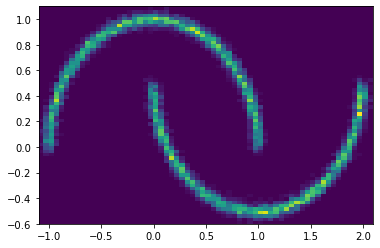

In [23]:
hist2d(samps[:,0],samps[:,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [24]:
# And just to compare, what would have happened if we only ran a normal
# HMC in the same conditions
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=dist_target.log_prob,
    num_leapfrog_steps=3,
    step_size=0.0125)

In [25]:
samples_hmc, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=np.zeros([1,2]),
      kernel=hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(0))

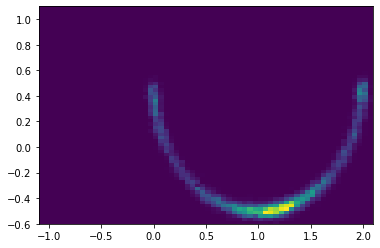

In [26]:
hist2d(samples_hmc[:,0,0],samples_hmc[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);